### Some Twitter Data!
Daniel Zheng

In [1]:
import seaborn as sns
import tweepy as tp
import pandas as pd

In [2]:
key, secret = open('api_key.txt').read().splitlines()

In [3]:
auth = tp.OAuthHandler(consumer_key=key, consumer_secret=secret)
api = tp.API(auth)

In [4]:
trump = api.user_timeline(id='realDonaldTrump') # last 20 tweets

In [9]:
# let's take a look at the first one!

# Status object has a ._json method!

last_id = trump[0]._json['id']
print('tweet url: https://twitter.com/i/web/status/{}'.format(last_id))
# list of last 100 tweets as json objects
# probably limited by tweepy to limit stressing twitter servers
retweets = [x._json for x in api.retweets(id=last_id,count=100)] 
print('got {} retweets!'.format(len(retweets))) # ... unreliable, won't get exactly 100. oh well!

tweet url: https://twitter.com/i/web/status/915745470689005573
got 90 retweets!


In [10]:
from dateutil import parser
# creating a dataframe of these tweets
columns = ['timestamp', 'name', 'location']
formatted_retweets = []
for rt in retweets:
    # could get more user info, but keeping to this for now
    formatted_retweets.append([parser.parse(rt['created_at']), rt['user']['name'], rt['user']['location']]) 


In [11]:
tweets_df = pd.DataFrame(formatted_retweets, columns=columns)

In [12]:
tweets_df.head() 

,timestamp,name,location
0,2017-10-05 04:58:39+00:00,JOSEPH BRANCATO,
1,2017-10-05 04:58:35+00:00,Morgan,
2,2017-10-05 04:58:27+00:00,Sheilak55,
3,2017-10-05 04:58:20+00:00,CHARLENE BRICKEY,
4,2017-10-05 04:58:13+00:00,M. Allard,


In [13]:
print(list(tweets_df['location']))

['', '', '', '', '', '', '', 'Texas, USA', '', 'Seattle, WA', '', '', '', '', 'Cape Coral, FL', 'Texas, USA', 'Philippines', 'Ventura County, California', 'Florida, USA', 'Greenwood, IN', 'Tulsa, OK', 'So CAL', '', 'San Diego, CA ', 'Somewhere in the great state of Virginia. ', 'California, USA', 'United States', 'Chattanooga, TN', 'New York. LI.', '', '', '', '', 'United Kingdom', 'United States', '', '', '', 'Wilmington, Delaware', 'Alabaster, AL', '', 'New York, NY', 'Scottsdale, Arizona', 'Hamstead London', 'Dębe Wielkie, Polska', 'Dehradun, India', 'New Caney, TX', '', 'Indiana, USA', '', 'Colorado Springs, CO', 'Georgetown ', '', '', 'Mishawaka, IN', 'United States of America', 'Altoona PA', 'Bullhead City, AZ', 'Las Vegas, NV', 'TrumpTrain, USA', '', 'Elo Hell, California', '', '', 'TEXAS MOTHER FUCKERS', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'Texas, USA', '', 'Syracuse, NY', 'Houston Texas', '120 May Street, Orange City, F', 'The Golden State', '', 'Mount Olym

In [14]:
# looks like a bunch of empty strings when a location isn't found, so that's fine.
tweets_df = tweets_df[tweets_df['location'] != ''].reset_index(drop=True) # reset index from 0
tweets_df = tweets_df.sort_values('timestamp')

What to do now? Maybe plotting retweets on a map could be interesting!

In [15]:
from geopy.geocoders import Nominatim
import re
locator = Nominatim()

def get_coords(place):
    # regex attempt to help with weird location names..
    cleaned_place = ' '.join(re.split('[^a-zA-Z]', place)) 
    print(cleaned_place)
    location = locator.geocode(cleaned_place)
    if location is not None:
        return location.longitude, location.latitude
    return None

In [16]:
tweets_df['long-lat'] = tweets_df['location'].map(get_coords) # yikes this is slow
tweets_df = tweets_df[~tweets_df['long-lat'].isnull()]

Springfield College     
Mount Olympus
The Golden State
    May Street  Orange City  F
Houston Texas
Syracuse  NY
Texas  USA
TEXAS MOTHER FUCKERS
Elo Hell  California
TrumpTrain  USA
Las Vegas  NV
Bullhead City  AZ
Altoona PA
United States of America
Mishawaka  IN
Georgetown 
Colorado Springs  CO
Indiana  USA
New Caney  TX
Dehradun  India
D be Wielkie  Polska
Hamstead London
Scottsdale  Arizona
New York  NY
Alabaster  AL
Wilmington  Delaware
United States
United Kingdom
New York  LI 
Chattanooga  TN
United States
California  USA
Somewhere in the great state of Virginia  
San Diego  CA 
So CAL
Tulsa  OK
Greenwood  IN
Florida  USA
Ventura County  California
Philippines
Texas  USA
Cape Coral  FL
Seattle  WA
Texas  USA


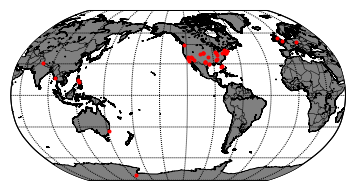

In [17]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

lons = []
lats = []

fig, ax = plt.subplots()
# 'f' for full resolution, kinda slow
world_map = Basemap(projection='robin', resolution = 'h', area_thresh = 1000.0,
              lat_0=0, lon_0=-130)
world_map.drawcoastlines()
world_map.drawcountries()
world_map.fillcontinents(color = 'gray')
world_map.drawmapboundary()
world_map.drawmeridians(np.arange(0, 360, 30))
world_map.drawparallels(np.arange(-90, 90, 30))

x,y = world_map(0, 0)
point = world_map.plot(x, y, 'ro', markersize=3)[0]

def init():
    point.set_data([], [])
    return point,
def animate(i):
    if i < len(tweets_df):
        lons.append(tweets_df.iloc[i]['long-lat'][0])
        lats.append(tweets_df.iloc[i]['long-lat'][1])
        x, y = world_map(lons, lats)
        point.set_data(x, y)
    return point,

anim = animation.FuncAnimation(plt.gcf(), animate, init_func=init,
                               frames=len(tweets_df), interval=200, blit=True)
HTML(anim.to_html5_video())


In [18]:
# would've liked to use tweepy's streaming features to livestream retweets
# download as html to view video!